In [1]:
import torch
from torch import nn
from torch.nn import functional as F

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import time
from tabulate import tabulate


from trainer import Trainer, generate_data_iter
import utils
import attack
import cam

In [2]:
model_mode, dataset, seed, cuda = 'resnet18', 'CIFAR10', 0, 2
target_layer = 'layer4' if model_mode == 'resnet18' else 'blocks'
fig_num = 400
metrics = {}

trainer = Trainer(
    model_mode = model_mode,
    dataset = dataset,
    bs = 128,
    lr = 0.01,
    seed = seed,
    cuda = cuda,
    use_lr_sche = True,
    use_wandb = False,
)
trainer.load()
scorecam = cam.ScoreCAM(trainer.model, dataset, target_layer, cuda = cuda)

# Generate Test data
test_iter = generate_data_iter(dataset, batch_size = fig_num, mode = 'test')
imgs, labels = next(iter(test_iter))
raw_cam_nps, raw_preds, _, __ = scorecam(imgs, metric = False)

# Extract Successful Results
suc_indices = raw_preds == labels
suc_imgs, suc_labels = imgs[suc_indices], labels[suc_indices]
suc_cams, suc_saliency_maps, suc_preds, suc_probs, suc_cam_metrics \
    = scorecam(suc_imgs, metric = True, saliency = True)


metrics['Raw'] = {
    'time': 0,
    'success_rate': 1,
    'delta_norm': 0,
    'Average Incr': suc_cam_metrics['Average Incr'], 
    'Average Drop': suc_cam_metrics['Average Drop'],
    'Insertion':  suc_cam_metrics['Insertion'], 
    'Deletion': suc_cam_metrics['Deletion'],
    'saliency_diff': 0,
    'shift_dist': 0
}
print(tabulate(
    list(metrics['Raw'].items()), tablefmt ='orgtbl'
))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
{'time': 0, 'success_rate': 1, 'delta_norm': 0, 'Average Incr': 0.3509235084056854, 'Average Drop': 0.006324526853859425, 'Insertion': 0.7219066365001624, 'Deletion': 0.33556587325807763, 'saliency_diff': 0, 'shift_dist': 0}


In [25]:
def test_advatt(att, att_kwargs: dict = {}):
    start = time.time()
    attacks = att(
        suc_imgs, suc_labels, max_iter = 5, num_classes = 10, attack_kwargs = att_kwargs
    )
    finish = time.time()
    deltas = attacks - suc_imgs

    att_cams, att_saliency_maps, att_preds, __, att_cam_metrics \
        = scorecam(attacks, metric = True, saliency = True)

    # Success Rate
    success_rate = (att_preds != suc_labels).sum() / len(att_preds)

    # delta norm
    delta_norm = torch.mean(
        torch.linalg.norm(deltas.reshape(len(deltas), -1), dim = 1) \
            / torch.linalg.norm(suc_imgs.reshape(len(deltas), -1), dim = 1)
    )

    # delta saliency map norm
    saliency_diff = np.linalg.norm(
        att_saliency_maps - suc_saliency_maps,
        axis = (1, 2)
    ).mean()

    # maximum shift
    size = imgs.shape[-1]
    suc_max_idx_raw = np.argmax(suc_saliency_maps.reshape(len(suc_saliency_maps), -1), axis = 1)
    suc_max_x, suc_max_y = suc_max_idx_raw // size, suc_max_idx_raw % size

    att_max_idx_raw = np.argmax(att_saliency_maps.reshape(len(att_saliency_maps), -1), axis = 1)
    att_max_x, att_max_y = att_max_idx_raw // size, suc_max_idx_raw % size
    shift_dist = np.sqrt((att_max_x - suc_max_x)**2 + (att_max_y - suc_max_y)**2).mean()
    
    metrics = {
        'time': finish - start,
        'success_rate': success_rate.item(),
        'delta_norm': delta_norm.item(),
        'Average Incr': att_cam_metrics['Average Incr'], 
        'Average Drop': att_cam_metrics['Average Drop'],
        'Insertion':  att_cam_metrics['Insertion'], 
        'Deletion': att_cam_metrics['Deletion'],
        'saliency_diff': saliency_diff,
        'shift_dist': shift_dist
    }
    return attacks, att_cams, metrics

def plot_imgs(
    raw_img: torch.Tensor,
    att_img: torch.Tensor,
    suc_cam: np.ndarray,
    att_cam: np.ndarray
):
    fig = plt.figure(figsize = (12, 3))
    plt.subplot(1, 4, 1)
    plt.imshow(np.transpose(raw_img.numpy(), (1, 2, 0)))
    plt.title('Raw')
    plt.axis('off')
    
    plt.subplot(1, 4, 2)
    plt.imshow(np.transpose(att_img.numpy(), (1, 2, 0)))
    plt.title('Attack')
    plt.axis('off')
    
    plt.subplot(1, 4, 3)
    plt.imshow(suc_cam)
    plt.axis('off')
    
    plt.subplot(1, 4, 4)
    plt.imshow(att_cam)
    plt.axis('off')

### FGSM

In [23]:
att = attack.FGSM(trainer.model, cuda)
att_name = att.__class__.__name__
att_kwargs = {'eps': 0.05}
att_imgs, att_cams, metrics[att_name] = test_advatt(att, att_kwargs)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

100%|██████████| 379/379 [00:03<00:00, 118.03it/s]


| time          | 3.21272   |
| success_rate  | 0.852243  |
| delta_norm    | 0.0989221 |
| Average Incr  | 0.738786  |
| Average Drop  | 0.0129536 |
| Insertion     | 0.58754   |
| Deletion      | 0.269025  |
| saliency_diff | 8.5148    |
| shift_dist    | 6.32982   |


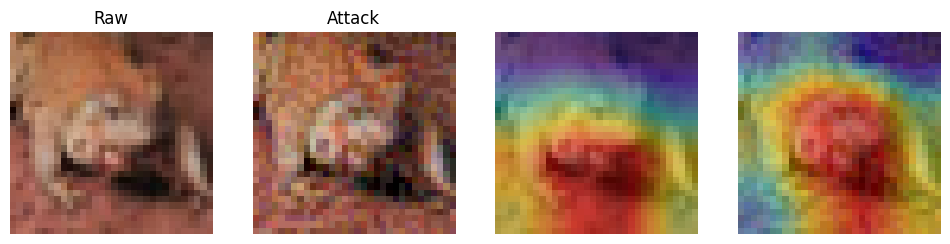

In [26]:
idx = 4
plot_imgs(
    suc_imgs[idx], att_imgs[idx], 
    suc_cams[idx], att_cams[idx]
)

### FGM

In [35]:
att = attack.FGM(trainer.model, cuda)
att_name = att.__class__.__name__
att_kwargs = {'eps': 1}
att_imgs, att_cams, metrics[att_name] = test_advatt(att, att_kwargs)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

100%|██████████| 379/379 [00:03<00:00, 119.27it/s]


| time          | 3.19088   |
| success_rate  | 0.717678  |
| delta_norm    | 0.0359267 |
| Average Incr  | 0.701847  |
| Average Drop  | 0.0137969 |
| Insertion     | 0.62591   |
| Deletion      | 0.299057  |
| saliency_diff | 7.4072    |
| shift_dist    | 5.56728   |


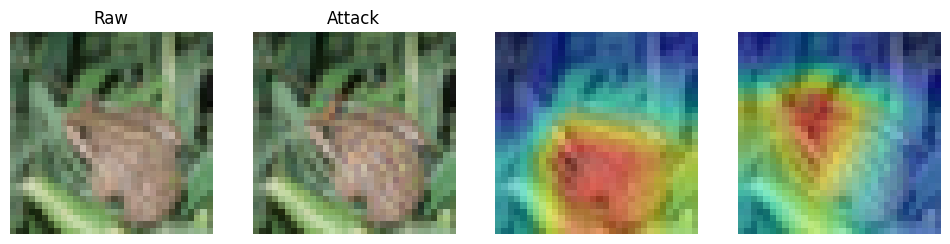

In [36]:
idx = 3
plot_imgs(
    suc_imgs[idx], att_imgs[idx], 
    suc_cams[idx], att_cams[idx]
)

### I-FGSM

In [6]:
att = attack.IFGSM(trainer.model)
att_name = att.__class__.__name__
attacks = torch.zeros_like(suc_imgs)
start = time.time()
with trange(len(suc_imgs)) as t:
    for i in t:
        attacks[i] = att(suc_imgs[i], suc_labels[i])
final = time.time()

deltas = attacks - suc_imgs
norm = torch.mean(
    torch.linalg.norm(deltas.reshape(len(deltas), -1), dim = 1) \
        / torch.linalg.norm(suc_imgs.reshape(len(deltas), -1), dim = 1)
)

att_preds, att_probs = trainer.model_predict(attacks)
success_rate = (att_preds != suc_labels).sum() / len(att_preds)
print(f'{att_name}:\tSuccess Rate: {success_rate * 100:4.2f}%,  Norm: {norm:.3e},  Avg Time: {(final - start)/fig_num:.3f}s')
metrics[att_name] = {
    'success_rate': (success_rate * 100).item(),
    'norm': norm.item(),
    'time': final - start
}

100%|██████████| 379/379 [00:14<00:00, 26.07it/s]


IFGSM:	Success Rate: 100.00%,  Norm: 2.316e-01,  Avg Time: 0.036s


### PGD

In [3]:
att = attack.IFGSM(trainer.model)
att_name = att.__class__.__name__
attacks = torch.zeros_like(suc_imgs)
start = time.time()
with trange(len(suc_imgs)) as t:
    for i in t:
        attacks[i] = att(suc_imgs[i], suc_labels[i])
final = time.time()

deltas = attacks - suc_imgs
norm = torch.mean(
    torch.linalg.norm(deltas.reshape(len(deltas), -1), dim = 1) \
        / torch.linalg.norm(suc_imgs.reshape(len(deltas), -1), dim = 1)
)

att_preds, att_probs = trainer.model_predict(attacks)
success_rate = (att_preds != suc_labels).sum() / len(att_preds)
print(f'{att_name}:\tSuccess Rate: {success_rate * 100:4.2f}%,  Norm: {norm:.3e},  Avg Time: {(final - start)/fig_num:.3f}s')
metrics[att_name] = {
    'success_rate': (success_rate * 100).item(),
    'norm': norm.item(),
    'time': final - start
}

100%|██████████| 379/379 [00:25<00:00, 14.87it/s]


IFGSM:	Success Rate: 100.00%,  Norm: 2.318e-01,  Avg Time: 0.064s


### MIFGSM

In [7]:
att = attack.MIFGSM(trainer.model)
att_name = att.__class__.__name__
attacks = torch.zeros_like(suc_imgs)
start = time.time()
with trange(len(suc_imgs)) as t:
    for i in t:
        attacks[i] = att(suc_imgs[i], suc_labels[i])
final = time.time()

deltas = attacks - suc_imgs
norm = torch.mean(
    torch.linalg.norm(deltas.reshape(len(deltas), -1), dim = 1) \
        / torch.linalg.norm(suc_imgs.reshape(len(deltas), -1), dim = 1)
)

att_preds, att_probs = trainer.model_predict(attacks)
success_rate = (att_preds != suc_labels).sum() / len(att_preds)
print(f'{att_name}:\tSuccess Rate: {success_rate * 100:4.2f}%,  Norm: {norm:.3e},  Avg Time: {(final - start)/fig_num:.3f}s')
metrics[att_name] = {
    'success_rate': (success_rate * 100).item(),
    'norm': norm.item(),
    'time': final - start
}

100%|██████████| 379/379 [00:14<00:00, 26.06it/s]


MIFGSM:	Success Rate: 100.00%,  Norm: 2.402e-01,  Avg Time: 0.036s


### NIFGSM

In [8]:
att = attack.NIFGSM(trainer.model)
att_name = att.__class__.__name__
attacks = torch.zeros_like(suc_imgs)
start = time.time()
with trange(len(suc_imgs)) as t:
    for i in t:
        attacks[i] = att(suc_imgs[i], suc_labels[i])
final = time.time()

deltas = attacks - suc_imgs
norm = torch.mean(
    torch.linalg.norm(deltas.reshape(len(deltas), -1), dim = 1) \
        / torch.linalg.norm(suc_imgs.reshape(len(deltas), -1), dim = 1)
)

att_preds, att_probs = trainer.model_predict(attacks)
success_rate = (att_preds != suc_labels).sum() / len(att_preds)
print(f'{att_name}:\tSuccess Rate: {success_rate * 100:4.2f}%,  Norm: {norm:.3e},  Avg Time: {(final - start)/fig_num:.3f}s')
metrics[att_name] = {
    'success_rate': (success_rate * 100).item(),
    'norm': norm.item(),
    'time': final - start
}

100%|██████████| 379/379 [00:14<00:00, 26.59it/s]


NIFGSM:	Success Rate: 100.00%,  Norm: 2.403e-01,  Avg Time: 0.036s


### Step-LL

In [9]:
att = attack.StepLL(trainer.model)
att_name = att.__class__.__name__
attacks = torch.zeros_like(suc_imgs)
start = time.time()
with trange(len(suc_imgs)) as t:
    for i in t:
        attacks[i] = att(suc_imgs[i], 10, eps = 0.05)
final = time.time()

deltas = attacks - suc_imgs
norm = torch.mean(
    torch.linalg.norm(deltas.reshape(len(deltas), -1), dim = 1) \
        / torch.linalg.norm(suc_imgs.reshape(len(deltas), -1), dim = 1)
)

att_preds, att_probs = trainer.model_predict(attacks)
success_rate = (att_preds != suc_labels).sum() / len(att_preds)
print(f'{att_name}:\tSuccess Rate: {success_rate * 100:4.2f}%,  Norm: {norm:.3e},  Avg Time: {(final - start)/fig_num:.3f}s')
metrics[att_name] = {
    'success_rate': (success_rate * 100).item(),
    'norm': norm.item(),
    'time': final - start
}

100%|██████████| 379/379 [00:04<00:00, 88.59it/s]


StepLL:	Success Rate: 80.21%,  Norm: 9.893e-02,  Avg Time: 0.011s


## IterLL

In [10]:
att = attack.IterLL(trainer.model)
att_name = att.__class__.__name__
attacks = torch.zeros_like(suc_imgs)
start = time.time()
with trange(len(suc_imgs)) as t:
    for i in t:
        attacks[i] = att(suc_imgs[i], 10)
final = time.time()

deltas = attacks - suc_imgs
norm = torch.mean(
    torch.linalg.norm(deltas.reshape(len(deltas), -1), dim = 1) \
        / torch.linalg.norm(suc_imgs.reshape(len(deltas), -1), dim = 1)
)

att_preds, att_probs = trainer.model_predict(attacks)
success_rate = (att_preds != suc_labels).sum() / len(att_preds)
print(f'{att_name}:\tSuccess Rate: {success_rate * 100:4.2f}%,  Norm: {norm:.3e},  Avg Time: {(final - start)/fig_num:.3f}s')
metrics[att_name] = {
    'success_rate': (success_rate * 100).item(),
    'norm': norm.item(),
    'time': final - start
}

100%|██████████| 379/379 [00:15<00:00, 24.52it/s]


IterLL:	Success Rate: 100.00%,  Norm: 2.307e-01,  Avg Time: 0.039s


### Deep Fool

In [11]:
att = attack.DeepFool(trainer.model)
att_name = att.__class__.__name__
attacks = torch.zeros_like(suc_imgs)
start = time.time()
with trange(len(suc_imgs)) as t:
    for i in t:
        attacks[i] = att(suc_imgs[i], 10)
final = time.time()

deltas = attacks - suc_imgs
norm = torch.mean(
    torch.linalg.norm(deltas.reshape(len(deltas), -1), dim = 1) \
        / torch.linalg.norm(suc_imgs.reshape(len(deltas), -1), dim = 1)
)

att_preds, att_probs = trainer.model_predict(attacks)
success_rate = (att_preds != suc_labels).sum() / len(att_preds)
print(f'{att_name}:\tSuccess Rate: {success_rate * 100:4.2f}%,  Norm: {norm:.3e},  Avg Time: {(final - start)/fig_num:.3f}s')
metrics[att_name] = {
    'success_rate': (success_rate * 100).item(),
    'norm': norm.item(),
    'time': final - start
}

100%|██████████| 379/379 [00:21<00:00, 17.77it/s]

DeepFool:	Success Rate: 90.24%,  Norm: 2.793e-01,  Avg Time: 0.053s


### One Pixel

In [12]:
# att = attack.OnePixel(trainer.model)
# att_name = att.__class__.__name__
# attacks = torch.zeros_like(suc_imgs)
# start = time.time()
# with trange(len(suc_imgs)) as t:
#     for i in t:
#         attacks[i] = att(suc_imgs[i], suc_labels[i], 100, 400)
# final = time.time()

# deltas = attacks - suc_imgs
# norm = torch.mean(
#     torch.linalg.norm(deltas.reshape(len(deltas), -1), dim = 1) \
#         / torch.linalg.norm(suc_imgs.reshape(len(deltas), -1), dim = 1)
# )

# att_preds, att_probs = trainer.model_predict(attacks)
# success_rate = (att_preds != suc_labels).sum() / len(att_preds)
# print(f'{att_name}:\tSuccess Rate: {success_rate * 100:4.2f}%,  Norm: {norm:.3e},  Avg Time: {(final - start)/fig_num:.3f}s')
# metrics[att_name] = {
#     'success_rate': success_rate * 100,
#     'norm': norm,
#     'time': final - start
# }

In [13]:
metrics_df = pd.DataFrame(metrics)

In [14]:
metrics_df

,FGSM,FGM,IFGSM,MIFGSM,NIFGSM,StepLL,IterLL,DeepFool
success_rate,83.641159,82.849602,100.000000,100.000000,100.000000,80.211082,100.000000,90.237465
norm,0.195761,0.311550,0.231609,0.240249,0.240260,0.098932,0.230711,0.279301
time,3.564740,2.955983,14.544076,14.546105,14.254607,4.280385,15.462418,21.326583


In [15]:
metrics_df.to_csv('./results/attack_metrics.csv')